In [1]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
!pip install pyreadstat

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler

In [3]:
def preprocess(df):
    df.Tx = df.Tx.apply(lambda x: 0 if x=='0:C' else 1).values.tolist()
        
    df.Tier = df.Tier.apply(lambda x: 1 if x=='Tier 1' else x).values.tolist()
    df.Tier = df.Tier.apply(lambda x: 2 if x=='Tier 2' else x).values.tolist()
    df.Tier = df.Tier.apply(lambda x: 3 if x=='Tier 3' else x).values.tolist()
    df.Cohort = df.Cohort.apply(lambda x: 1 if x=='Study 1' else 2).values.tolist()

In [4]:
column_names = ['StuID', 'Gender', 'Tier', 'SchlID', 'TeachID', 'LEP',
       'SpEd', 'Tx', 'Cohort', 'Keep', 'Age1b', 'Tier2_N', 'grp_rate',
       'rcmistot', 'gnrl_fid', 'TKPctCrct', 'Tier2MinRd', 'TYearsTeaching',
       'Time', 't', 'NWFcls', 'NWFwrc', 'ORFwc', 'SAwrS', 'SAsrS', 'SAtoS',
       'RMwidRS', 'RMwdaRS']


# column_names = ['StuID', 'SchlID', 'Tier', 't',
#                 'Gender', 'Tx', 'Age1b',  'Tier2_N', 'grp_rate',
#                    'rcmistot', 'gnrl_fid', 'TKPctCrct', 'NWFcls', 
#                    'NWFwrc', 'ORFwc', 'SAwrS', 'SAsrS', 'SAtoS',
#                    'RMwidRS', 'RMwdaRS']

df = pd.read_spss("/kaggle/input/student-performance/Ms_Study12Tier12.sav", usecols=column_names)
preprocess(df)
data = df.dropna()

data_t0 = data[data['t']==0]
data_t1 = data[data['t']==1]
data_merged = data_t0.merge(data_t1, how = 'inner', on='StuID')

data_all = df.dropna(subset=['RMwidRS', 'RMwdaRS'])
data_all = data_all.fillna(-1)
data_all_t0 = data_all[data_all['t']==0]
data_all_t1 = data_all[data_all['t']==1]
data_all_merged = data_all_t0.merge(data_all_t1, how = 'inner', on='StuID')



# data = df

# preprocess(data_t0)
# preprocess(data_t1)



In [5]:
data.shape

(1406, 28)

In [6]:
df.Tier.value_counts()

Tier
1.0    12728
2.0     6248
3.0     5556
Name: count, dtype: int64

In [7]:
data_all.Tier.value_counts()

Tier
2.0    1970
1.0      22
3.0      13
Name: count, dtype: int64

In [8]:
data_ctrl = data_merged[data_merged["Tx_x"]==0]
data_intn = data_merged[data_merged["Tx_x"]==1]

RMwidRS_ref = np.mean(data_ctrl.iloc[:, 53]-data_ctrl.iloc[:, 26])
RMwdaRS_ref = np.mean(data_ctrl.iloc[:, 54]-data_ctrl.iloc[:, 27])



data_merged["RMwidRS_target"] = (data_merged.RMwidRS_y-data_merged.RMwidRS_x).apply(lambda x: 0 if x-RMwidRS_ref<0 else 1)
data_merged["RMwdaRS_target"] = (data_merged.RMwdaRS_y-data_merged.RMwdaRS_x).apply(lambda x: 0 if x-RMwdaRS_ref<0 else 1)

data_ctrl["RMwidRS_target"] = (data_ctrl.RMwidRS_y-data_ctrl.RMwidRS_x).apply(lambda x: 0 if x-RMwidRS_ref<0 else 1)
data_ctrl["RMwdaRS_target"] = (data_ctrl.RMwdaRS_y-data_ctrl.RMwdaRS_x).apply(lambda x: 0 if x-RMwdaRS_ref<0 else 1)

data_intn["RMwidRS_target"] = (data_intn.RMwidRS_y-data_intn.RMwidRS_x).apply(lambda x: 0 if x-RMwidRS_ref<0 else 1)
data_intn["RMwdaRS_target"] = (data_intn.RMwdaRS_y-data_intn.RMwdaRS_x).apply(lambda x: 0 if x-RMwdaRS_ref<0 else 1)

data_all_merged["RMwidRS_target"] = (data_all_merged.RMwidRS_y-data_all_merged.RMwidRS_x).apply(lambda x: 0 if x-RMwidRS_ref<0 else 1)
data_all_merged["RMwdaRS_target"] = (data_all_merged.RMwdaRS_y-data_all_merged.RMwdaRS_x).apply(lambda x: 0 if x-RMwdaRS_ref<0 else 1)

In [9]:
data_all_merged.shape

(946, 57)

In [10]:
data_merged["RMwidRS_target"].value_counts()

RMwidRS_target
1    344
0    331
Name: count, dtype: int64

In [11]:
feature_columns = ['Gender_x', 'Tx_x', 'Age1b_x',  'Tier2_N_x', 'grp_rate_x',
                   'rcmistot_x', 'gnrl_fid_x', 'TKPctCrct_x', 'NWFcls_x', 
                   'NWFwrc_x', 'ORFwc_x', 'SAwrS_x', 'SAsrS_x', 'SAtoS_x',
                   'RMwidRS_x', 'RMwdaRS_x']
feature_columns_noTx = ['Gender_x', 'Age1b_x',  'Tier2_N_x', 'grp_rate_x',
                   'rcmistot_x', 'gnrl_fid_x', 'TKPctCrct_x', 'NWFcls_x', 
                   'NWFwrc_x', 'ORFwc_x', 'SAwrS_x', 'SAsrS_x', 'SAtoS_x',
                   'RMwidRS_x', 'RMwdaRS_x']

selected_features_wid = ["Tier2_N_x", "TKPctCrct_x", "NWFwrc_x",  'SAsrS_x', 'SAtoS_x', 'RMwidRS_x', 'RMwdaRS_x']

selected_features_wda = ["Tx_x", "NWFwrc_x", "ORFwc_x", "SAwrS_x", "SAtoS_x", "RMwdaRS_x"]

target_columns = ["RMwidRS_target", "RMwdaRS_target"]
split_coumns= ["StuID", "SchlID"]

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

In [13]:
class StudentDataset(Dataset):
    def __init__(self, data, features, label):
        super(StudentDataset, self).__init__()
        self.x = torch.tensor(data[features].values, dtype=torch.float32)
        self.y = torch.tensor(data[label].values, dtype=torch.float32)
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [14]:
class StudentDatasetPretrain(Dataset):
    def __init__(self, data, features, label):
        super(StudentDatasetPretrain, self).__init__()
        self.x = torch.tensor(data[features].values, dtype=torch.float32)
        self.y = torch.tensor(data[label].values, dtype=torch.float32)
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        random_other = np.random.randint(0, self.x.shape[0])
        if self.y[idx] == self.y[random_other]:
            return (self.x[idx], self.x[random_other]), torch.tensor([1.], dtype=torch.float32)
        else:
            return (self.x[idx], self.x[random_other]), torch.tensor([0.], dtype=torch.float32)

In [15]:
# class StudentMLP(nn.Module):
#     def __init__(self, input_dim, output_dim=1, num_layers=3, hidden_size=64):
#         super(StudentMLP, self).__init__()
        
#         self.head = nn.Sequential(nn.Linear(input_dim, hidden_size), nn.ReLU(), nn.LazyBatchNorm1d())
#         self.fc = nn.Sequential(*[nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.LazyBatchNorm1d()) for _ in range(num_layers)])
#         self.tail = nn.Sequential(nn.Linear(hidden_size, output_dim), nn.Sigmoid())
#         self.pretrain = nn.Sequential(nn.Linear(hidden_size, input_dim))
        
#     def forward(self, x, pretrain=False):
#         x = self.head(x)
#         x = self.fc(x)
#         if pretrain:
#             x = self.pretrain(x)
#         else:
#             x = self.tail(x)
        
#         return x

class StudentMLP(nn.Module):
    def __init__(self, input_dim, output_dim=1, num_layers=3, hidden_size=64):
        super(StudentMLP, self).__init__()
        
        self.head = nn.Sequential(nn.Linear(input_dim, hidden_size), nn.ReLU(), nn.LazyBatchNorm1d())
        self.fc = nn.Sequential(*[nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.LazyBatchNorm1d()) for _ in range(num_layers)])
        self.tail = nn.Sequential(nn.Linear(hidden_size, output_dim), nn.Sigmoid())
#         self.pretrain = nn.Sequential(nn.Linear(hidden_size, input_dim))
        self.pretrain = nn.Sequential(nn.Linear(hidden_size, hidden_size))
        
        
        
    def forward(self, x1, x2=None, pretrain=False):
        if pretrain:
            x1 = self.head(x1)
            x1 = self.fc(x1)
#             x1 = self.pretrain(x1)
            
            x2 = self.head(x2)
            x2 = self.fc(x2)
#             x2 = self.pretrain(x2)
            return x1, x2
        else:
            x1 = self.head(x1)
            x1 = self.fc(x1)
            x1 = self.tail(x1)
            return x1

In [16]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [17]:
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True).pow(2)

        loss_contrastive = torch.mean((1 - target) * euclidean_distance +
                                      target * torch.clamp(self.margin - euclidean_distance, min=0.0))

        return loss_contrastive

In [18]:
np.random.uniform()

0.3745401188473625

fold 0 training, target :RMwidRS_target
#training samples 540, #valid samples 135
epoch 25: accuracy:0.5704, specificity: 0.3182, sensitivity:0.8116, balanced_score: 0.5649, auc: 0.5649
epoch 50: accuracy:0.6370, specificity: 0.4394, sensitivity:0.8261, balanced_score: 0.6327, auc: 0.6327
epoch 75: accuracy:0.6593, specificity: 0.5606, sensitivity:0.7536, balanced_score: 0.6571, auc: 0.6571
epoch 100: accuracy:0.6593, specificity: 0.5909, sensitivity:0.7246, balanced_score: 0.6578, auc: 0.6578
epoch 125: accuracy:0.6370, specificity: 0.5909, sensitivity:0.6812, balanced_score: 0.6360, auc: 0.6360
epoch 150: accuracy:0.6296, specificity: 0.5303, sensitivity:0.7246, balanced_score: 0.6275, auc: 0.6275
epoch 175: accuracy:0.6593, specificity: 0.6515, sensitivity:0.6667, balanced_score: 0.6591, auc: 0.6591
epoch 200: accuracy:0.6519, specificity: 0.6061, sensitivity:0.6957, balanced_score: 0.6509, auc: 0.6509
epoch 225: accuracy:0.6444, specificity: 0.6061, sensitivity:0.6812, balanced_sco

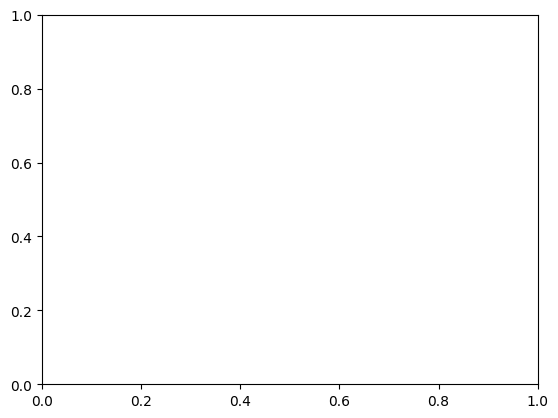

In [19]:
## Student ID split, all fe, RMwidRS_target

gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score, auc_score = 0, 0, 0, 0, 0
b_accuracy, b_specificity, b_sensitivity, b_balanced_score, b_auc_score = 0, 0, 0, 0, 0

fig, ax = plt.subplots()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns], data_merged[target], groups=data_merged.StuID)):
    
    X_train = data_merged[feature_columns+[target]].iloc[train_idx]
    X_valid = data_merged[feature_columns+[target]].iloc[val_idx]
    X_pretrain = data_all_merged[feature_columns+[target]]
    
    train_dataset = StudentDataset(X_train, feature_columns, target)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    
    valid_dataset = StudentDataset(X_valid, feature_columns, target)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
    
    pretrain_dataset = StudentDatasetPretrain(X_pretrain, feature_columns, target)
    pretrain_loader = DataLoader(pretrain_dataset, batch_size=16, shuffle=True)
    
    input_dim = data_merged[feature_columns].shape[-1]
    model = StudentMLP(input_dim)
    
    
    criterion = nn.BCELoss()
    aug_loss = nn.CosineEmbeddingLoss() # nn.MSELoss(), nn.KLDivLoss() nn.CosineEmbeddingLoss()
    pretrain_loss = ContrastiveLoss(margin=1.0)
#     pretrain_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.001)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 250, 2)
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    print(f"#training samples {len(train_dataset)}, #valid samples {len(valid_dataset)}")
    best_accuracy, best_specificity, best_sensitivity, best_balanced_score, best_auc_score = 0, 0, 0, 0, 0
    
    
    for epoch in range(200):
        model.train()
        
        for step, ((x1, x2), y) in enumerate(pretrain_loader):
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            if np.random.uniform()>0.0:
                x2 = x1.clone()
                x2[:, np.random.randint(0,16,12)] = -1
                y1, y2 = model(x1, x2, pretrain=True)
                optimizer.zero_grad()
                loss = aug_loss(y1,y2, torch.ones(y1.size(0)).to(device))
                loss.backward()
                optimizer.step()
            else:
                y1, y2 = model(x1, x2, pretrain=True)
                optimizer.zero_grad()
                loss = pretrain_loss(y1.squeeze(1), y2.squeeze(1), y)
                loss.backward()
                optimizer.step()
            
#             scheduler.step(epoch+step/len(train_loader))
#         print(loss)
    
#     for param in model.head.parameters():
#         param.requires_grad = False
#     for param in model.fc.parameters():
#         param.requires_grad = False

    for epoch in range(1000):
        model.train()
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_ = model(x)
            loss = criterion(y_.squeeze(1), y)
            loss.backward()
            optimizer.step()
            scheduler.step(epoch+step/len(train_loader))
            
        model.eval() 
        with torch.no_grad():
            for i, (x, y) in enumerate(valid_loader):
                x, y = x.to(device), y.to(device)
                y_ = model(x)
                if i==0:
                    y_gt = y
                    y_pred = y_
                else:
#                     print(y_gt.shape, y_pred.shape, y.shape, y_.shape)
                    y_gt = torch.concat([y_gt, y])
                    y_pred = torch.concat([y_pred, y_])
        y_gt = y_gt.detach().cpu().numpy()
        y_pred = y_pred.squeeze(1).detach().cpu().numpy()
        
        logit = np.copy(y_pred)
        
        y_pred[y_pred>0.5] = 1
        y_pred[y_pred<=0.5] = 0
        
        acc = accuracy_score(y_gt, y_pred)
        ba = balanced_accuracy_score(y_gt, y_pred)
        prec,recall,_,_ = precision_recall_fscore_support(y_gt, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
        auc = roc_auc_score(y_gt, y_pred)
        
        if acc>best_accuracy:
            best_accuracy = acc
            best_specificity = recall[0]
            best_sensitivity = recall[1] 
            best_balanced_score = ba 
            best_auc_score = auc
            
            np.save(f"{target}_fold_{fold_n}_SchlID.npy", {"StuID":data_merged.iloc[val_idx].StuID, "pred": y_pred, "logit":logit})
            
#         best_accuracy = acc if acc>best_accuracy else best_accuracy
#         best_specificity = recall[0] if recall[0]>best_specificity else best_specificity
#         best_sensitivity = recall[1] if recall[1]>best_sensitivity else best_sensitivity
#         best_balanced_score = ba if ba>best_balanced_score else best_balanced_score
#         best_auc_score = auc if auc>best_auc_score else best_auc_score
        
        if (epoch+1)%25==0:
            print(f"epoch {epoch+1}: accuracy:{acc:.4f}, specificity: {recall[0]:.4f}, sensitivity:{recall[1]:.4f}, balanced_score: {ba:.4f}, auc: {auc:.4f}")
    
    print(f"epoch {epoch+1}: best_accuracy:{best_accuracy:.4f}, best_specificity: {best_specificity:.4f}, best_sensitivity:{best_sensitivity:.4f}, best_balanced_score: {best_balanced_score:.4f}, best_auc_score: {best_auc_score:.4f}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    auc_score += auc
    balanced_score += ba
    
    b_accuracy += best_accuracy
    b_specificity += best_specificity
    b_sensitivity += best_sensitivity
    b_auc_score += best_auc_score
    b_balanced_score += best_balanced_score
    
print(f"Overall: accuracy:{accuracy/5:.4f}, specificity: {specificity/5:.4f}, sensitivity:{sensitivity/5:.4f}, balanced_score: {balanced_score/5:.4f}, auc: {auc_score/5:.4f}")
print(f"Overall Best: accuracy:{b_accuracy/5:.4f}, specificity: {b_specificity/5:.4f}, sensitivity:{b_sensitivity/5:.4f}, balanced_score: {b_balanced_score/5:.4f}, auc: {b_auc_score/5:.4f}")

fold 0 training, target :RMwdaRS_target
#training samples 540, #valid samples 135
epoch 25: accuracy:0.6370, specificity: 0.0784, sensitivity:0.9762, balanced_score: 0.5273, auc: 0.5273
epoch 50: accuracy:0.6148, specificity: 0.0980, sensitivity:0.9286, balanced_score: 0.5133, auc: 0.5133
epoch 75: accuracy:0.6296, specificity: 0.1765, sensitivity:0.9048, balanced_score: 0.5406, auc: 0.5406
epoch 100: accuracy:0.6370, specificity: 0.1569, sensitivity:0.9286, balanced_score: 0.5427, auc: 0.5427
epoch 125: accuracy:0.6593, specificity: 0.1961, sensitivity:0.9405, balanced_score: 0.5683, auc: 0.5683
epoch 150: accuracy:0.6593, specificity: 0.1961, sensitivity:0.9405, balanced_score: 0.5683, auc: 0.5683
epoch 175: accuracy:0.6444, specificity: 0.2157, sensitivity:0.9048, balanced_score: 0.5602, auc: 0.5602
epoch 200: accuracy:0.6296, specificity: 0.1765, sensitivity:0.9048, balanced_score: 0.5406, auc: 0.5406
epoch 225: accuracy:0.6444, specificity: 0.1961, sensitivity:0.9167, balanced_sco

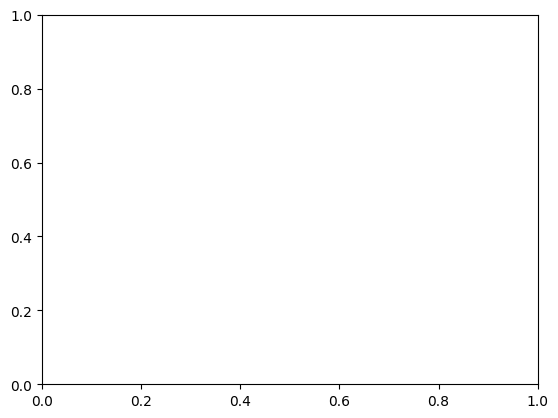

In [20]:
## Student ID split, all fe, RMwidRS_target

gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score, auc_score = 0, 0, 0, 0, 0
b_accuracy, b_specificity, b_sensitivity, b_balanced_score, b_auc_score = 0, 0, 0, 0, 0

fig, ax = plt.subplots()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns], data_merged[target], groups=data_merged.StuID)):
    
    X_train = data_merged[feature_columns+[target]].iloc[train_idx]
    X_valid = data_merged[feature_columns+[target]].iloc[val_idx]
    X_pretrain = data_all_merged[feature_columns+[target]]
    
    train_dataset = StudentDataset(X_train, feature_columns, target)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    
    valid_dataset = StudentDataset(X_valid, feature_columns, target)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
    
    pretrain_dataset = StudentDatasetPretrain(X_pretrain, feature_columns, target)
    pretrain_loader = DataLoader(pretrain_dataset, batch_size=16, shuffle=True)
    
    input_dim = data_merged[feature_columns].shape[-1]
    model = StudentMLP(input_dim)
    
    
    criterion = nn.BCELoss()
    aug_loss = nn.CosineEmbeddingLoss() # nn.MSELoss(), nn.KLDivLoss() nn.CosineEmbeddingLoss()
    pretrain_loss = ContrastiveLoss(margin=1.0)
#     pretrain_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.001)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 250, 2)
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    print(f"#training samples {len(train_dataset)}, #valid samples {len(valid_dataset)}")
    best_accuracy, best_specificity, best_sensitivity, best_balanced_score, best_auc_score = 0, 0, 0, 0, 0
    
    
    for epoch in range(200):
        model.train()
        
        for step, ((x1, x2), y) in enumerate(pretrain_loader):
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            if np.random.uniform()>0.0:
                x2 = x1.clone()
                x2[:, np.random.randint(0,16,12)] = -1
                y1, y2 = model(x1, x2, pretrain=True)
                optimizer.zero_grad()
                loss = aug_loss(y1,y2, torch.ones(y1.size(0)).to(device))
                loss.backward()
                optimizer.step()
            else:
                y1, y2 = model(x1, x2, pretrain=True)
                optimizer.zero_grad()
                loss = pretrain_loss(y1.squeeze(1), y2.squeeze(1), y)
                loss.backward()
                optimizer.step()
            
#             scheduler.step(epoch+step/len(train_loader))
#         print(loss)
    
#     for param in model.head.parameters():
#         param.requires_grad = False
#     for param in model.fc.parameters():
#         param.requires_grad = False

    for epoch in range(1000):
        model.train()
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_ = model(x)
            loss = criterion(y_.squeeze(1), y)
            loss.backward()
            optimizer.step()
            scheduler.step(epoch+step/len(train_loader))
            
        model.eval() 
        with torch.no_grad():
            for i, (x, y) in enumerate(valid_loader):
                x, y = x.to(device), y.to(device)
                y_ = model(x)
                if i==0:
                    y_gt = y
                    y_pred = y_
                else:
#                     print(y_gt.shape, y_pred.shape, y.shape, y_.shape)
                    y_gt = torch.concat([y_gt, y])
                    y_pred = torch.concat([y_pred, y_])
        y_gt = y_gt.detach().cpu().numpy()
        y_pred = y_pred.squeeze(1).detach().cpu().numpy()
        
        logit = np.copy(y_pred)
        
        y_pred[y_pred>0.5] = 1
        y_pred[y_pred<=0.5] = 0
        
        acc = accuracy_score(y_gt, y_pred)
        ba = balanced_accuracy_score(y_gt, y_pred)
        prec,recall,_,_ = precision_recall_fscore_support(y_gt, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
        auc = roc_auc_score(y_gt, y_pred)
        
        if acc>best_accuracy:
            best_accuracy = acc
            best_specificity = recall[0]
            best_sensitivity = recall[1] 
            best_balanced_score = ba 
            best_auc_score = auc
            
            np.save(f"{target}_fold_{fold_n}_SchlID.npy", {"StuID":data_merged.iloc[val_idx].StuID, "pred": y_pred, "logit":logit})
#         best_accuracy = acc if acc>best_accuracy else best_accuracy
#         best_specificity = recall[0] if recall[0]>best_specificity else best_specificity
#         best_sensitivity = recall[1] if recall[1]>best_sensitivity else best_sensitivity
#         best_balanced_score = ba if ba>best_balanced_score else best_balanced_score
#         best_auc_score = auc if auc>best_auc_score else best_auc_score
        
        if (epoch+1)%25==0:
            print(f"epoch {epoch+1}: accuracy:{acc:.4f}, specificity: {recall[0]:.4f}, sensitivity:{recall[1]:.4f}, balanced_score: {ba:.4f}, auc: {auc:.4f}")
    
    print(f"epoch {epoch+1}: best_accuracy:{best_accuracy:.4f}, best_specificity: {best_specificity:.4f}, best_sensitivity:{best_sensitivity:.4f}, best_balanced_score: {best_balanced_score:.4f}, best_auc_score: {best_auc_score:.4f}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    auc_score += auc
    balanced_score += ba
    
    b_accuracy += best_accuracy
    b_specificity += best_specificity
    b_sensitivity += best_sensitivity
    b_auc_score += best_auc_score
    b_balanced_score += best_balanced_score
    
print(f"Overall: accuracy:{accuracy/5:.4f}, specificity: {specificity/5:.4f}, sensitivity:{sensitivity/5:.4f}, balanced_score: {balanced_score/5:.4f}, auc: {auc_score/5:.4f}")
print(f"Overall Best: accuracy:{b_accuracy/5:.4f}, specificity: {b_specificity/5:.4f}, sensitivity:{b_sensitivity/5:.4f}, balanced_score: {b_balanced_score/5:.4f}, auc: {b_auc_score/5:.4f}")

fold 0 training, target :RMwidRS_target
#training samples 539, #valid samples 136
epoch 25: accuracy:0.5956, specificity: 0.4068, sensitivity:0.7403, balanced_score: 0.5735, auc: 0.5735
epoch 50: accuracy:0.6103, specificity: 0.5085, sensitivity:0.6883, balanced_score: 0.5984, auc: 0.5984
epoch 75: accuracy:0.6544, specificity: 0.6102, sensitivity:0.6883, balanced_score: 0.6492, auc: 0.6492
epoch 100: accuracy:0.6691, specificity: 0.6102, sensitivity:0.7143, balanced_score: 0.6622, auc: 0.6622
epoch 125: accuracy:0.6618, specificity: 0.6102, sensitivity:0.7013, balanced_score: 0.6557, auc: 0.6557
epoch 150: accuracy:0.6765, specificity: 0.5763, sensitivity:0.7532, balanced_score: 0.6648, auc: 0.6648
epoch 175: accuracy:0.6765, specificity: 0.6441, sensitivity:0.7013, balanced_score: 0.6727, auc: 0.6727
epoch 200: accuracy:0.6912, specificity: 0.6271, sensitivity:0.7403, balanced_score: 0.6837, auc: 0.6837
epoch 225: accuracy:0.6765, specificity: 0.6271, sensitivity:0.7143, balanced_sco

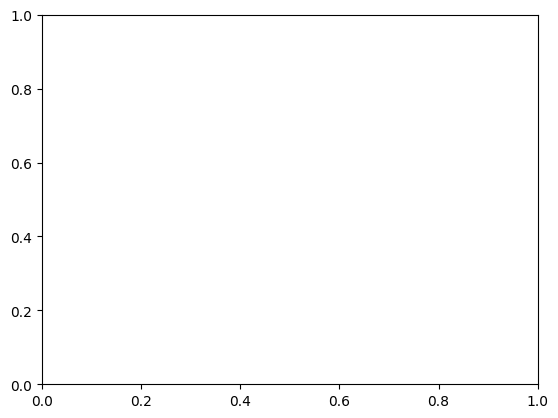

In [21]:
## Student ID split, all fe, RMwidRS_target

gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score, auc_score = 0, 0, 0, 0, 0
b_accuracy, b_specificity, b_sensitivity, b_balanced_score, b_auc_score = 0, 0, 0, 0, 0

fig, ax = plt.subplots()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns], data_merged[target], groups=data_merged.SchlID_x)):
    
    X_train = data_merged[feature_columns+[target]].iloc[train_idx]
    X_valid = data_merged[feature_columns+[target]].iloc[val_idx]
    X_pretrain = data_all_merged[feature_columns+[target]]
    
    train_dataset = StudentDataset(X_train, feature_columns, target)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    
    valid_dataset = StudentDataset(X_valid, feature_columns, target)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
    
    pretrain_dataset = StudentDatasetPretrain(X_pretrain, feature_columns, target)
    pretrain_loader = DataLoader(pretrain_dataset, batch_size=16, shuffle=True)
    
    input_dim = data_merged[feature_columns].shape[-1]
    model = StudentMLP(input_dim)
    
    
    criterion = nn.BCELoss()
    aug_loss = nn.CosineEmbeddingLoss() # nn.MSELoss(), nn.KLDivLoss() nn.CosineEmbeddingLoss()
    pretrain_loss = ContrastiveLoss(margin=1.0)
#     pretrain_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.001)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 250, 2)
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    print(f"#training samples {len(train_dataset)}, #valid samples {len(valid_dataset)}")
    best_accuracy, best_specificity, best_sensitivity, best_balanced_score, best_auc_score = 0, 0, 0, 0, 0
    
    
    for epoch in range(200):
        model.train()
        
        for step, ((x1, x2), y) in enumerate(pretrain_loader):
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            if np.random.uniform()>0.0:
                x2 = x1.clone()
                x2[:, np.random.randint(0,16,12)] = -1
                y1, y2 = model(x1, x2, pretrain=True)
                optimizer.zero_grad()
                loss = aug_loss(y1,y2, torch.ones(y1.size(0)).to(device))
                loss.backward()
                optimizer.step()
            else:
                y1, y2 = model(x1, x2, pretrain=True)
                optimizer.zero_grad()
                loss = pretrain_loss(y1.squeeze(1), y2.squeeze(1), y)
                loss.backward()
                optimizer.step()
            
#             scheduler.step(epoch+step/len(train_loader))
#         print(loss)
    
#     for param in model.head.parameters():
#         param.requires_grad = False
#     for param in model.fc.parameters():
#         param.requires_grad = False

    for epoch in range(1000):
        model.train()
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_ = model(x)
            loss = criterion(y_.squeeze(1), y)
            loss.backward()
            optimizer.step()
            scheduler.step(epoch+step/len(train_loader))
            
        model.eval() 
        with torch.no_grad():
            for i, (x, y) in enumerate(valid_loader):
                x, y = x.to(device), y.to(device)
                y_ = model(x)
                if i==0:
                    y_gt = y
                    y_pred = y_
                else:
#                     print(y_gt.shape, y_pred.shape, y.shape, y_.shape)
                    y_gt = torch.concat([y_gt, y])
                    y_pred = torch.concat([y_pred, y_])
        y_gt = y_gt.detach().cpu().numpy()
        y_pred = y_pred.squeeze(1).detach().cpu().numpy()
        
        logit = np.copy(y_pred)
        
        y_pred[y_pred>0.5] = 1
        y_pred[y_pred<=0.5] = 0
        
        acc = accuracy_score(y_gt, y_pred)
        ba = balanced_accuracy_score(y_gt, y_pred)
        prec,recall,_,_ = precision_recall_fscore_support(y_gt, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
        auc = roc_auc_score(y_gt, y_pred)
        
        if acc>best_accuracy:
            best_accuracy = acc
            best_specificity = recall[0]
            best_sensitivity = recall[1] 
            best_balanced_score = ba 
            best_auc_score = auc
            
            np.save(f"{target}_fold_{fold_n}SchlID.npy", {"StuID":data_merged.iloc[val_idx].StuID, "pred": y_pred, "logit":logit})
#         best_accuracy = acc if acc>best_accuracy else best_accuracy
#         best_specificity = recall[0] if recall[0]>best_specificity else best_specificity
#         best_sensitivity = recall[1] if recall[1]>best_sensitivity else best_sensitivity
#         best_balanced_score = ba if ba>best_balanced_score else best_balanced_score
#         best_auc_score = auc if auc>best_auc_score else best_auc_score
        
        if (epoch+1)%25==0:
            print(f"epoch {epoch+1}: accuracy:{acc:.4f}, specificity: {recall[0]:.4f}, sensitivity:{recall[1]:.4f}, balanced_score: {ba:.4f}, auc: {auc:.4f}")
    
    print(f"epoch {epoch+1}: best_accuracy:{best_accuracy:.4f}, best_specificity: {best_specificity:.4f}, best_sensitivity:{best_sensitivity:.4f}, best_balanced_score: {best_balanced_score:.4f}, best_auc_score: {best_auc_score:.4f}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    auc_score += auc
    balanced_score += ba
    
    b_accuracy += best_accuracy
    b_specificity += best_specificity
    b_sensitivity += best_sensitivity
    b_auc_score += best_auc_score
    b_balanced_score += best_balanced_score
    
print(f"Overall: accuracy:{accuracy/5:.4f}, specificity: {specificity/5:.4f}, sensitivity:{sensitivity/5:.4f}, balanced_score: {balanced_score/5:.4f}, auc: {auc_score/5:.4f}")
print(f"Overall Best: accuracy:{b_accuracy/5:.4f}, specificity: {b_specificity/5:.4f}, sensitivity:{b_sensitivity/5:.4f}, balanced_score: {b_balanced_score/5:.4f}, auc: {b_auc_score/5:.4f}")

fold 0 training, target :RMwdaRS_target
#training samples 539, #valid samples 136
epoch 25: accuracy:0.5735, specificity: 0.1333, sensitivity:0.9211, balanced_score: 0.5272, auc: 0.5272
epoch 50: accuracy:0.6029, specificity: 0.1333, sensitivity:0.9737, balanced_score: 0.5535, auc: 0.5535
epoch 75: accuracy:0.5882, specificity: 0.0833, sensitivity:0.9868, balanced_score: 0.5351, auc: 0.5351
epoch 100: accuracy:0.5662, specificity: 0.0667, sensitivity:0.9605, balanced_score: 0.5136, auc: 0.5136
epoch 125: accuracy:0.5515, specificity: 0.1500, sensitivity:0.8684, balanced_score: 0.5092, auc: 0.5092
epoch 150: accuracy:0.5588, specificity: 0.1500, sensitivity:0.8816, balanced_score: 0.5158, auc: 0.5158
epoch 175: accuracy:0.5515, specificity: 0.1333, sensitivity:0.8816, balanced_score: 0.5075, auc: 0.5075
epoch 200: accuracy:0.5588, specificity: 0.1833, sensitivity:0.8553, balanced_score: 0.5193, auc: 0.5193
epoch 225: accuracy:0.5735, specificity: 0.2167, sensitivity:0.8553, balanced_sco

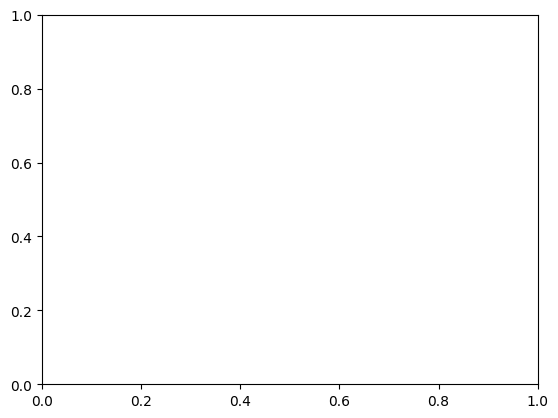

In [22]:
## Student ID split, all fe, RMwidRS_target

gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score, auc_score = 0, 0, 0, 0, 0
b_accuracy, b_specificity, b_sensitivity, b_balanced_score, b_auc_score = 0, 0, 0, 0, 0

fig, ax = plt.subplots()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns], data_merged[target], groups=data_merged.SchlID_x)):
    
    X_train = data_merged[feature_columns+[target]].iloc[train_idx]
    X_valid = data_merged[feature_columns+[target]].iloc[val_idx]
    X_pretrain = data_all_merged[feature_columns+[target]]
    
    train_dataset = StudentDataset(X_train, feature_columns, target)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    
    valid_dataset = StudentDataset(X_valid, feature_columns, target)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
    
    pretrain_dataset = StudentDatasetPretrain(X_pretrain, feature_columns, target)
    pretrain_loader = DataLoader(pretrain_dataset, batch_size=16, shuffle=True)
    
    input_dim = data_merged[feature_columns].shape[-1]
    model = StudentMLP(input_dim)
    
    
    criterion = nn.BCELoss()
    aug_loss = nn.CosineEmbeddingLoss() # nn.MSELoss(), nn.KLDivLoss() nn.CosineEmbeddingLoss()
    pretrain_loss = ContrastiveLoss(margin=1.0)
#     pretrain_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.001)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 250, 2)
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    print(f"#training samples {len(train_dataset)}, #valid samples {len(valid_dataset)}")
    best_accuracy, best_specificity, best_sensitivity, best_balanced_score, best_auc_score = 0, 0, 0, 0, 0
    
    
    for epoch in range(200):
        model.train()
        
        for step, ((x1, x2), y) in enumerate(pretrain_loader):
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            if np.random.uniform()>0.0:
                x2 = x1.clone()
                x2[:, np.random.randint(0,16,12)] = -1
                y1, y2 = model(x1, x2, pretrain=True)
                optimizer.zero_grad()
                loss = aug_loss(y1,y2, torch.ones(y1.size(0)).to(device))
                loss.backward()
                optimizer.step()
            else:
                y1, y2 = model(x1, x2, pretrain=True)
                optimizer.zero_grad()
                loss = pretrain_loss(y1.squeeze(1), y2.squeeze(1), y)
                loss.backward()
                optimizer.step()
            
#             scheduler.step(epoch+step/len(train_loader))
#         print(loss)
    
#     for param in model.head.parameters():
#         param.requires_grad = False
#     for param in model.fc.parameters():
#         param.requires_grad = False

    for epoch in range(1000):
        model.train()
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_ = model(x)
            loss = criterion(y_.squeeze(1), y)
            loss.backward()
            optimizer.step()
            scheduler.step(epoch+step/len(train_loader))
            
        model.eval() 
        with torch.no_grad():
            for i, (x, y) in enumerate(valid_loader):
                x, y = x.to(device), y.to(device)
                y_ = model(x)
                if i==0:
                    y_gt = y
                    y_pred = y_
                else:
#                     print(y_gt.shape, y_pred.shape, y.shape, y_.shape)
                    y_gt = torch.concat([y_gt, y])
                    y_pred = torch.concat([y_pred, y_])
        y_gt = y_gt.detach().cpu().numpy()
        y_pred = y_pred.squeeze(1).detach().cpu().numpy()
        
        logit = np.copy(y_pred)
        
        y_pred[y_pred>0.5] = 1
        y_pred[y_pred<=0.5] = 0
        
        acc = accuracy_score(y_gt, y_pred)
        ba = balanced_accuracy_score(y_gt, y_pred)
        prec,recall,_,_ = precision_recall_fscore_support(y_gt, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
        auc = roc_auc_score(y_gt, y_pred)
        
        if acc>best_accuracy:
            best_accuracy = acc
            best_specificity = recall[0]
            best_sensitivity = recall[1] 
            best_balanced_score = ba 
            best_auc_score = auc
            
            np.save(f"{target}_fold_{fold_n}SchlID.npy", {"StuID":data_merged.iloc[val_idx].StuID, "pred": y_pred, "logit":logit})

            
#         best_accuracy = acc if acc>best_accuracy else best_accuracy
#         best_specificity = recall[0] if recall[0]>best_specificity else best_specificity
#         best_sensitivity = recall[1] if recall[1]>best_sensitivity else best_sensitivity
#         best_balanced_score = ba if ba>best_balanced_score else best_balanced_score
#         best_auc_score = auc if auc>best_auc_score else best_auc_score
        
        if (epoch+1)%25==0:
            print(f"epoch {epoch+1}: accuracy:{acc:.4f}, specificity: {recall[0]:.4f}, sensitivity:{recall[1]:.4f}, balanced_score: {ba:.4f}, auc: {auc:.4f}")
    
    print(f"epoch {epoch+1}: best_accuracy:{best_accuracy:.4f}, best_specificity: {best_specificity:.4f}, best_sensitivity:{best_sensitivity:.4f}, best_balanced_score: {best_balanced_score:.4f}, best_auc_score: {best_auc_score:.4f}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    auc_score += auc
    balanced_score += ba
    
    b_accuracy += best_accuracy
    b_specificity += best_specificity
    b_sensitivity += best_sensitivity
    b_auc_score += best_auc_score
    b_balanced_score += best_balanced_score
    
print(f"Overall: accuracy:{accuracy/5:.4f}, specificity: {specificity/5:.4f}, sensitivity:{sensitivity/5:.4f}, balanced_score: {balanced_score/5:.4f}, auc: {auc_score/5:.4f}")
print(f"Overall Best: accuracy:{b_accuracy/5:.4f}, specificity: {b_specificity/5:.4f}, sensitivity:{b_sensitivity/5:.4f}, balanced_score: {b_balanced_score/5:.4f}, auc: {b_auc_score/5:.4f}")